In [27]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.integrate as integrate
from numba import jit

Question #1

We seek to build a model similar to that of the Firm Dynamics model with capital adjustment cost, and adding in randomly drawn shocks to operating profit. The functional form is as follows:

$$ V(z,k) = max_{k'} \pi(z,k) - p^{k}(k'-(1-\delta)k) - c(k',k) + \beta V(z',k') $$

We begin by establishing parameters, generating a grid from which to draw our capital levels, and creating a set of z-shocks.

In [28]:
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
z = 1
betafirm = (1 / (1 + r))
rho = 0.7605
mu = 0.0
sigma_eps = 0.213
dens = 1
sigma_z = sigma_eps / ((1 - rho ** 2) ** (1 / 2))
N = 9
num_draws = 100000


# kstar is the analytical solution from the deterministic problem
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) ** (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (z ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))

lb_k = 0.001
ub_k = 2*kstar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

We now generate our z-values

In [29]:
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu
z_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)- norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))+ mu)
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]

print(z_grid)

[-0.55913938 -0.32004072 -0.19425291 -0.09290094  0.          0.09290094
  0.19425291  0.32004072  0.55913938]


The computation then follows as before:

In [18]:
op = np.zeros((len(z_grid),len(kvec)))
for k in range(len(z_grid)):
    z = z_grid[k]
    op[k] = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) 
                 * ((kvec ** alpha_k) ** (1 / (1 - alpha_l))) * np.exp(z_grid[k])**(1 / (1 - alpha_l)))


e = np.zeros((len(z_grid),sizek, sizek))
for k in range(len(z_grid)):
    z = z_grid[k]
    for i in range(sizek):
        for j in range(sizek):
            e[k,i,j] = ((op[k,i] - kvec[j]) + ((1 - delta) * kvec[i]) - ((psi / 2) * ((kvec[j] - 
                        ((1 - delta) * kvec[i])) ** 2)/ kvec[i]))

Value function converged after this many iterations: 365
VFI took  0.5041640677222275  seconds to solve


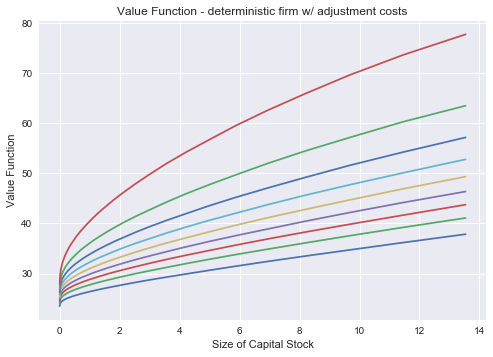

In [6]:
# generating shocks

            
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((len(z_grid),sizek))  # initial guess at value function
Vmat = np.zeros((len(z_grid),sizek, sizek))  # initialize Vmat matrix
VFiter = 0
start_time = time.clock()

@jit
def prob1(V,Vmat,e):
    for k in range(len(z_grid)):  # loop over z
        for i in range(sizek):  # loop over k
            for j in range(sizek):  # loop over k'
                Vmat[k, i, j] = e[k, i, j] + betafirm * V[k,j]
    return Vmat


while VFdist > VFtol and VFiter < VFmaxiter:    
    TV = V
    V = pi @ V
    Vmat = prob1(V,Vmat,e)
    V = Vmat.max(axis=2)  # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=2)  # find the index of the optimal k'
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')

VF = V  # solution to the functional equation

'''
------------------------------------------------------------------------
Find optimal capital and investment policy functions
------------------------------------------------------------------------
optK = (sizek,) vector, optimal choice of k' for each k
optI = (sizek,) vector, optimal choice of investment for each k
------------------------------------------------------------------------
'''
optK = kvec[PF]
optI = optK - (1 - delta) * kvec
for i in range(len(z_grid)):
    plt.plot(kvec, VF[i])
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic firm w/ adjustment costs')
plt.show()

We now can discern the form of our policy functions for each starting z

NameError: name 'legend' is not defined

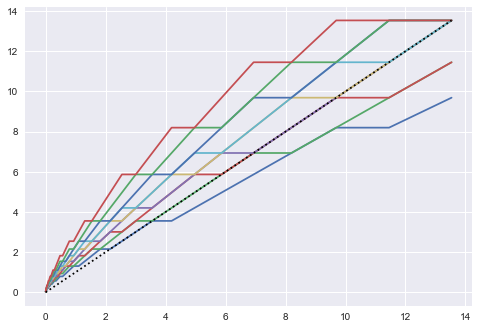

In [7]:
# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots()
for i in range(len(z_grid)):
    ax.plot(kvec, optK[i], label='Capital Next Period')
ax.plot(kvec, kvec, 'k:', label='45 degree line')
# Now add the legend with some customizations.
#legend = ax.legend(loc='upper left', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - deterministic firm w/ ' +
          'adjustment costs')

Question #2

As we now have a new value function, we must first re-establish the cash-flow calculations depending whether or not there is investment.

In [8]:
psi2 = 0.03

e1 = np.zeros((len(z_grid),sizek, sizek))
for k in range(len(z_grid)):
    z = z_grid[k]
    for i in range(sizek):
        for j in range(sizek):
            e1[k,i,j] = op[k,i] - kvec[j] + (1 - delta)*kvec[i] - (psi2)*(kvec[i])

e2 = np.zeros((len(z_grid),sizek, sizek))
for k in range(len(z_grid)):
    z = z_grid[k]
    for i in range(sizek):
        for j in range(sizek):
            e2[k,i,j] = op[k,i]

We now compare the two matrices and take the element-wise maxima. The motivation for this is that we $V(z,k)$ is equal to the maximum of the two functions above, given z, k, and k'.

In [9]:
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((len(z_grid),sizek))  # initial guess at value function
Vmat1 = np.zeros((len(z_grid),sizek, sizek))  # initialize Vmat matrix for investment chosen
Vmat2 = np.zeros((len(z_grid),sizek, sizek))  # initialize Vmat matrix for investment NOT chosen
VFiter = 0
start_time = time.clock()

@jit
def prob21(V,Vmat1,e1):
    for k in range(len(z_grid)):  # loop over z
        for i in range(sizek):  # loop over k
            for j in range(sizek):  # loop over k'
                Vmat1[k, i, j] = e1[k, i, j] + betafirm * V[k,j]
    return Vmat1

@jit
def prob22(V,Vmat2,e2):
    for k in range(len(z_grid)):  # loop over z
        for i in range(sizek):  # loop over k
            for j in range(sizek):  # loop over k'
                Vmat2[k, i, j] = e2[k, i, j] + betafirm * V[k,i-1]
    return Vmat2


while VFdist > VFtol and VFiter < VFmaxiter:    
    TV = V
    V = pi @ V
    Vmat1 = prob21(V,Vmat1,e1)
    Vmat2 = prob21(V,Vmat2,e2)
    Vmat  = np.maximum(Vmat1,Vmat2)
    V = Vmat.max(axis=2)  # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=2)  # find the index of the optimal k'
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')

VF = V  # solution to the functional equation

Value function converged after this many iterations: 410
VFI took  0.6212421972407505  seconds to solve


We now determine the policy function and graph:

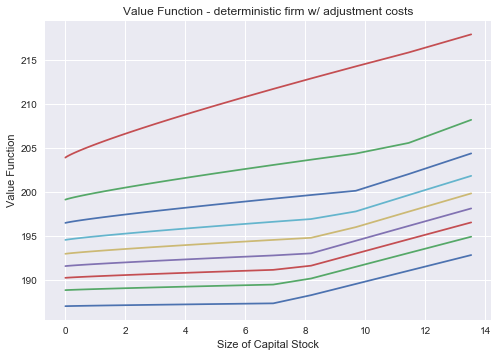

In [10]:
optK = kvec[PF]
optI = optK - (1 - delta) * kvec
for i in range(len(z_grid)):
    plt.plot(kvec, VF[i])
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic firm w/ adjustment costs')
plt.show()

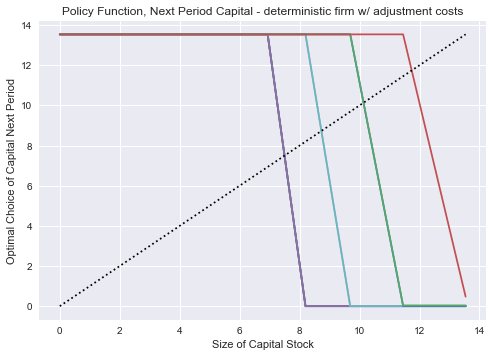

In [12]:
# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots()
for i in range(len(z_grid)):
    ax.plot(kvec, optK[i], label='Capital Next Period')
ax.plot(kvec, kvec, 'k:', label='45 degree line')
# Now add the legend with some customizations.
#legend = ax.legend(loc='upper left', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
#frame = legend.get_frame()
#frame.set_facecolor('0.90')
# Set the fontsize
#for label in legend.get_texts():
#    label.set_fontsize('large')
#for label in legend.get_lines():
#    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capital - deterministic firm w/ ' +
          'adjustment costs')

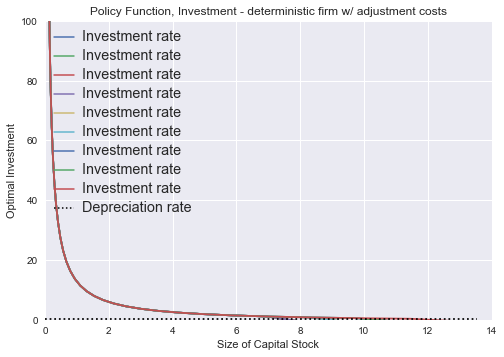

In [15]:
# Plot investment rule as a function of firm size
fig, ax = plt.subplots()
for i in range(len(z_grid)):
    ax.plot(kvec, (optI[i]/kvec), label='Investment rate')
ax.plot(kvec, (np.ones(sizek)*delta), 'k:', label='Depreciation rate')
plt.axis([0,14,0,100])
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Investment')
plt.title('Policy Function, Investment - deterministic firm w/ adjustment ' +
          'costs')

Question #3

Time Elapsed : 1.0758798122406006 seconds


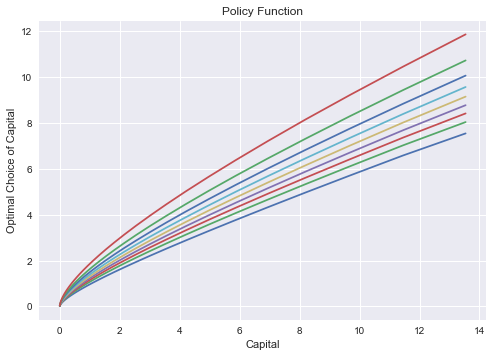

In [26]:
def profit_prime(z,kvec):
    profit = ( alpha_k * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) * ((kvec ** alpha_k) ** (alpha_l + alpha_k - 1 / (1 - alpha_l))) * np.exp(z)**(1 / (1 - alpha_l)))
    return profit

def cost_prime(kdbp,kp):
    cost = (psi / 2) * ((-2)*(kdbp - (1 - delta)*kp)*(1 - delta)*kp - (kdbp - (1 - delta)*kp)**2)/(kp**2)
    return cost

kmat = np.array([kvec for i in range(len(z_grid))])
kprimegrid = np.zeros(sizek)
kdbprimegrid = np.zeros(len(z_grid))

def coleman_egm(kvec,z_grid,kmat,kprimegrid,kdbprimegrid,pi,profit_prime,cost_prime):
    Kg = kmat.copy()
    for i,z in enumerate(z_grid):
        for j in range(sizek):
            for k in range(len(z_grid)):
                kdbprimegrid[k] = np.interp(kmat[i,j],kvec,kmat[k,:])
            kprimegrid[j] = ((psi * kmat[i,j])/( betafirm * ((profit_prime(z_grid,kmat[i,j]) + (1 - delta) 
                              - cost_prime(kdbprimegrid,kmat[i,j])) @ pi[:,i]) + psi * (1-delta) - 1))
        kmat[i,:] = np.interp(kvec,kprimegrid,kmat[i,:])
    tr = bool(np.absolute(kmat - Kg).max() < 0.0001)
    return kmat,tr

n = 100
tr = 1
def policyfunc(n,kvec,z_grid,kmat,kprimegrid,kdbprimegrid,pi,profit_prime,cost_prime):
    tr = 1
    for i in range(n):
        kmat,tr = coleman_egm(kvec,z_grid,kmat,kprimegrid,kdbprimegrid,pi,profit_prime,cost_prime)
        if tr == True:
            return kmat,tr
    return kmat,tr

start = time.time()
fkp,tr = policyfunc(n,kvec,z_grid,kmat,kprimegrid,kdbprimegrid,pi,profit_prime,cost_prime)
print("Time Elapsed :",time.time()-start, "seconds")
if tr == True:
    for z in range(len(z_grid)):
        plt.plot(kvec,fkp[z,:])
    plt.title("Policy Function")
    plt.xlabel("Capital")
    plt.ylabel("Optimal Choice of Capital")
    plt.show()

    

Note: I am unsure of what to do with the bonus, but I intend to send my code to Dr. DeBacker once I am done implementing the model with various taxes.